In [27]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import *
import matplotlib
import plplot
from scipy import stats
#from io import StringIO
print(pd.__version__)
#AttributeError: 'Series' object has no attribute 'to_numpy'

import math
import astropy as astro
import scipy.ndimage as spimage
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
import matplotlib as mpl
from numpy import std as biweight_midvariance
import matplotlib.cm as cm

from scipy import optimize
from scipy.stats import gaussian_kde
from matplotlib import colors




0.24.2


In [28]:
def make_colourmap(ind, red, green, blue, name):
    newInd = range(0, 256)
    r = np.interp(newInd, ind, red, left=None, right=None)
    g = np.interp(newInd, ind, green, left=None, right=None)
    b = np.interp(newInd, ind, blue, left=None, right=None)
    colours = np.transpose(np.asarray((r, g, b)))
    fctab= colours/255.0
    cmap = colors.ListedColormap(fctab, name=name,N=None)
    return cmap

def get_califa_velocity_cmap():
    ind = [1., 35., 90.,125.,160.,220.,255.]
    red = [148., 0., 0., 55.,221.,255.,255.]
    green = [ 0., 0.,191., 55.,160., 0.,165.]
    blue = [211.,128.,255., 55.,221., 0., 0.]
    return make_colourmap(ind, red, green, blue, 'califa_vel')


def get_califa_velocity_cmap_2():
    ind = [0., 1., 35., 90.,125.,160.,220.,255.]
    red = [ 0.,148., 0., 0., 55.,221.,255.,255.]
    green = [ 0., 0., 0.,191., 55.,160., 0.,165.]
    blue = [ 0.,211.,128.,255., 55.,221., 0., 0.]
    return make_colourmap(ind, red, green, blue, 'califa_vel')

def get_califa_intensity_cmap_2():
    ind = [ 0., 1., 50.,100.,150.,200.,255.]
    red = [ 0., 0., 0.,255.,255., 55.,221.]
    green =	[ 0., 0.,191., 0.,165., 55.,160.]
    blue = [ 0.,128.,255., 0., 0., 55.,221.]
    return make_colourmap(ind, red, green, blue, 'califa_int')


def get_califa_intensity_cmap():
    ind = [ 1., 50.,100.,150.,200.,255.]
    red = [ 0., 0.,255.,255., 55.,221.]
    green =	[ 0.,191., 0.,165., 55.,160.]
    blue = [ 128.,255., 0., 0., 55.,221.]
    return make_colourmap(ind, red, green, blue, 'califa_int')

#califa_vel = get_califa_velocity_cmap()
#califa_int = get_califa_intensity_cmap()
#califa_int=cm.nipy_spectral
califa_int=cm.Spectral
califa_vel=cm.Spectral




def fit_leastsq_pure(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq(errfunc, p0, args=(datax, datay), \
                          full_output=1, epsfcn=0.0001)

    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq 

def fit_leastsq(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq(errfunc, p0, args=(datax, datay), \
                          full_output=1, epsfcn=0.01)
# epsfcn=0.0001)


    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, pcov 



In [29]:
def binning_OH(M_OK, OH_Ref_OK, bin1 , min1 , max1 ):
    
    M_bin=[]
    OH_bin=[]
    D_OH_bin=[]
    
    OH_binM    = np.arange(min1,max1,bin1) 
    OH_binM = OH_binM-bin1*0.5
    m_range    = np.zeros(OH_binM.size)
    OH_binD    = np.zeros(OH_binM.size)

    for i, val  in enumerate(OH_binM):
        tmp = (OH_Ref_OK >= val) & (OH_Ref_OK <= val+bin1)
        m_sub=M_OK[tmp]
        n_vals=m_sub.size
        m_range[i]   = np.median(M_OK[tmp])
        OH_binD[i]   = np.std(OH_Ref_OK[tmp])
        if (n_vals > 10):
            M_bin.append(m_range[i])
            OH_bin.append(OH_binM[i])
            D_OH_bin.append(OH_binD[i])
    m_range=np.array(M_bin)
    OH_binM=np.array(OH_bin)
    OH_binD=np.array(D_OH_bin)
        
    return(m_range, OH_binM, OH_binD)
    
def binning(M_OK, OH_Ref_OK, bin1 , min1 , max1 ):
    
    
    m_range = np.arange(min1,max1,bin1)
    M_binM    = np.zeros(m_range.size)
    M_binV    = np.zeros(m_range.size)
    OH_binM    = np.zeros(m_range.size)
    OH_binD    = np.zeros(m_range.size)

    for i, val  in enumerate(m_range):
        tmp = (M_OK >= val) & (M_OK <= val+bin1)
        OH_binM[i]   = np.median(OH_Ref_OK[tmp])
        OH_binD[i]   = np.std(OH_Ref_OK[tmp])+0.02
#        tmp = (OH_Ref_OK >= OH_binM[i]-0.125*OH_binD[i]) & (OH_Ref_OK <= OH_binM[i]+0.125*OH_binD[i]) & (M_OK >= val-4*bin1) & (M_OK <= val+5*bin1)       
        tmp = (OH_Ref_OK >= OH_binM[i]-0.1*OH_binD[i]) & (OH_Ref_OK <= OH_binM[i]+0.1*OH_binD[i]) & (M_OK >= val-3*bin1) & (M_OK <= val+3*bin1)       

        M_binM[i]   = np.median(M_OK[tmp])
        M_binV[i] = val+0.5*bin1        
        if ((np.isnan(M_binM[i])) or (np.isinf(M_binM[i]))):
            M_binM[i]=M_binV[i]
    M_bin_out=0.5*(M_binM+M_binV)
    #print '',M_binM,M_binV,M_bin_out
    return(M_bin_out, OH_binM, OH_binD)

def binning_old(M_OK, OH_Ref_OK, bin1 , min1 , max1 ):
    
    
    m_range = np.arange(min1,max1,bin1)
    OH_binM    = np.zeros(m_range.size)
    OH_binD    = np.zeros(m_range.size)

    for i, val  in enumerate(m_range):
        tmp = (M_OK >= val) & (M_OK <= val+bin1)
        OH_binM[i]   = np.median(OH_Ref_OK[tmp])
        OH_binD[i]   = np.std(OH_Ref_OK[tmp])
            
    return(m_range, OH_binM, OH_binD)

def make_cont(x ,y, min2s,max2s,min1s,max1s,bin1s,bin2s, frac):

    m1s      = math.floor((max1s-min1s)/bin1s) + 1
    m2s      = math.floor((max2s-min2s)/bin2s) + 1
    
    vals, xedges, yedges = np.histogram2d(x, y, bins=[m1s,m2s])
    
    xbins = 0.5 * (xedges[:-1] + xedges[1:])
    ybins = 0.5 * (yedges[:-1] + yedges[1:])
    
    L = (1-frac)*(np.max(vals) - np.min(vals))+ np.min(vals)
    return(xbins, ybins, vals.T, L)

In [30]:
get_proc_file="get_proc_elines_MaNGA.no_nan.csv"
#get_proc_file="get_proc_elines_MaNGA.clean.csv"
#wholefile=StringIO(get_proc_file).read().split("#")[1]
#col_NAME=["name","nsa_redshift","nsa_u_absmag","nsa_z_absmag","nsa_u_z_absmag","nsa_mstar","nsa_inclination","nsa_petro_th50","nsa_sersic_ba","nsa_sersic_n","nsa_sersic_phi","nsa_sersic_th50","name","log_Mass_no_corr","lSFR","OH_O3N2","e_OH_O3N2","a_ion_cen[3]","frac_area_GAS","frac_area_SFR_pure","Av_w","OH_O3N2_Re","alpha_OH_O3N2_Re","a_vel_Ha_cen_mean","a_vel_ssp_cen_mean","z_gas","z_stars","FoV","nx","ny","Re_kpc","mag_g","log_Mass_corr","Av_ssp_stats[2]","OH_O3N2_Re2","e_OH_O3N2_Re2","error_Mass","e_lSFR","Age_LW_Re","e_Age_LW_Re","ZH_LW_Re","e_ZH_LW_Re","Av_LW_Re","e_Av_LW_Re","Av_gas_LW_Re","e_Av_gas_LW_Re","OH_Z_Re","e_ZH_LW_Re","log_age_mean_LW","s_log_age_mean_LW","log_ZH_mean_LW","s_log_ZH_mean_LW","Av_ssp_stats_mean","Av_ssp_stats_stddev","Av_w","e_Av_w","OH_Re_fit_O3N2","e_OH_Re_fit_O3N2","alpha_OH_Re_fit_O3N2","e_alpha_OH_Re_fit_O3N2","cc_r_OH_O3N2","sig_r_OH_O3N2","OH_Re_fit_N2","e_OH_Re_fit_N2","alpha_OH_Re_fit_N2","e_alpha_OH_Re_fit_N2","cc_r_OH_N2","sig_r_OH_N2","OH_Re_fit_ONS","e_OH_Re_fit_ONS","alpha_OH_Re_fit_ONS","e_alpha_OH_Re_fit_ONS","cc_r_OH_ONS","sig_r_OH_ONS","OH_Re_fit_R23","e_OH_Re_fit_R23","alpha_OH_Re_fit_R23","e_alpha_OH_Re_fit_R23","cc_r_OH_R23","sig_r_OH_R23","stats_OH_Re_mean_mean","stats_OH_Re_mean_stddev","stats_a_OH_Re_mean_mean","stats_a_OH_Re_mean_stddev","log_Mass","log_SFR_ssp","log_NII_Ha_cen_mean","log_NII_Ha_cen_stddev","log_OIII_Hb_cen_mean","log_OIII_Hb_cen_stddev","log_SII_Ha_cen_mean","log_SII_Ha_cen_stddev","log_OII_Hb_cen_mean","log_OII_Hb_cen_stddev","EW_Ha_cen_mean","EW_Ha_cen_stddev","stats_y_200_mean","stats_y_200_stddev","stats_y_30_mean","stats_y_30_stddev","stats_EW_Ha_mean","stats_EW_Ha_stddev","ZH_LW_Re_fit","e_ZH_LW_Re_fit","alpha_ZH_LW_Re_fit","e_alpha_ZH_LW_Re_fit","ZH_LW_lRe_fit","e_ZH_LW_lRe_fit","alpha_ZH_LW_lRe_fit","e_alpha_ZH_LW_lRe_fit","ZH_MW_Re_fit","e_ZH_MW_Re_fit","alpha_ZH_MW_Re_fit","e_alpha_ZH_MW_Re_fit","Age_LW_Re_fit","e_Age_LW_Re_fit","alpha_Age_LW_Re_fit","e_alpha_Age_LW_Re_fit","Age_LW_lRe_fit","e_Age_LW_lRe_fit","alpha_Age_LW_lRe_fit","e_alpha_Age_LW_lRe_fit","Age_MW_Re_fit","e_Age_MW_Re_fit","alpha_Age_MW_Re_fit","e_alpha_Age_MW_Re_fit","ZH_LW_Re_fit_0_0.5_Gyr","e_ZH_LW_Re_fit_0_0.5_Gyr","alpha_ZH_LW_Re_fit_0_0.5_Gyr","e_alpha_ZH_LW_Re_fit_0_0.5_Gyr","ZH_LW_Re_fit_0.5_2.0_Gyr","e_ZH_LW_Re_fit_0.5_2.0_Gyr","alpha_ZH_LW_Re_fit_0.5_2.0_Gyr","e_alpha_ZH_LW_Re_fit_0.5_2.0_Gyr","ZH_LW_Re_fit2.0_14.0_Gyr","e_ZH_LW_Re_fit2.0_14.0_Gyr","alpha_ZH_LW_Re_fit2.0_14.0_Gyr","e_alpha_ZH_LW_Re_fit2.0_14.0_Gyr","Re_arc","Re_kpc","DL","DA","P.A.","Ellipticity","Inclination","sigma_cen","e_sigma_cen","lambda_Re","e_lambda_Re","elip_ab","log_Mass_gas","log_Mass_gas_Re","log_Mass_gas_Av_ssp_ZH","log_Mass_gas_Av_ssp","log_Mass_gas_Av_gas_rad","log_Mass_stars_sigma","log_F_Ha","log_F_Ha_cor","log_L_Ha_cor","NH_Re_log","NO_Re_log","sigma_cen_Ha","e_sigma_cen_Ha","rat_vel_sigma","e_rat_vel_sigma","OH_Re_fit_pyqz","e_OH_Re_fit_pyqz","alpha_OH_Re_fit_pyqz","e_alpha_OH_Re_fit_pyqz","cc_r_OH_pyqz","sig_r_OH_pyqz","OH_Re_mean_phot","e_OH_Re_mean_phot","alpha_OH_Re_mean_phot","e_alpha_OH_Re_mean_phot","OH_ZH_LW_Re_fit","OH_ZH_LW_Re_fit_0_0.5Gyr","OH_ZH_LW_Re_fit_0.5_2Gyr","OH_ZH_LW_Re_fit_more_2Gyr","XC","YC","ZH_LW_Re_fit_0_2.0_Gyr","e_ZH_LW_Re_fit_0_2.0_Gyr","alpha_ZH_LW_Re_fit_0_2.0_Gyr","e_alpha_ZH_LW_Re_fit_0_2.0_Gyr","OH_ZH_LW_Re_fit_0_2Gyr","OH_ZH_MW_Re_fit","OH_ZH_MW_Re_fit_0_2Gyr","T50","T80","OH_ZH_LW_Re_fit_t50","OH_ZH_LW_Re_fit_M_t50","OH_ZH_LW_Re_fit_t80","OH_ZH_LW_Re_fit_M_t80","OH_Re_mean","e_OH_Re_mean","alpha_OH_Re_mean","e_alpha_OH_Re_mean","OH_Re_fit_mean","e_OH_Re_fit_mean","alpha_OH_Re_fit_mean","e_alpha_OH_Re_fit_mean","cc_r_OH_mean","sig_r_OH_mean","OH_Re_fit_t2","e_OH_Re_fit_t2","alpha_OH_Re_fit_t2","e_alpha_OH_Re_fit_t2","cc_r_OH_t2","sig_r_OH_t2","OH_ZH_LW_Re_fit_t90","OH_ZH_LW_Re_fit_M_t90","t90","t70","t60","ZH_LW_Re_fit_M_t50","e_ZH_LW_Re_fit_M_t50","alpha_ZH_LW_Re_fit_M_t50","e_alpha_ZH_LW_Re_fit_M_t50","cc_ZH_LW_Re_M_t50","sig_ZH_LW_Re_M_t50","ZH_LW_Re_fit_M_t60","e_ZH_LW_Re_fit_M_t60","alpha_ZH_LW_Re_fit_M_t60","e_alpha_ZH_LW_Re_fit_M_t60","cc_ZH_LW_Re_M_t60","sig_ZH_LW_Re_M_t60","ZH_LW_Re_fit_M_t70","e_ZH_LW_Re_fit_M_t70","alpha_ZH_LW_Re_fit_M_t70","e_alpha_ZH_LW_Re_fit_M_t70","cc_ZH_LW_Re_M_t70","sig_ZH_LW_Re_M_t70","ZH_LW_Re_fit_M_t80","e_ZH_LW_Re_fit_M_t80","alpha_ZH_LW_Re_fit_M_t80","e_alpha_ZH_LW_Re_fit_M_t80","cc_ZH_LW_Re_M_t80","sig_ZH_LW_Re_M_t80","ZH_LW_Re_fit_M_t90","e_ZH_LW_Re_fit_M_t90","alpha_ZH_LW_Re_fit_M_t90","e_alpha_ZH_LW_Re_fit_M_t90","cc_ZH_LW_Re_M_t90","sig_ZH_LW_Re_M_t90","ZH_LW_Re_fit_t50","e_ZH_LW_Re_fit_t50","alpha_ZH_LW_Re_fit_t50","e_alpha_ZH_LW_Re_fit_t50","cc_ZH_LW_Re_t50","sig_ZH_LW_Re_t50","ZH_LW_Re_fit_t60","e_ZH_LW_Re_fit_t60","alpha_ZH_LW_Re_fit_t60","e_alpha_ZH_LW_Re_fit_t60","cc_ZH_LW_Re_t60","sig_ZH_LW_Re_t60","ZH_LW_Re_fit_t70","e_ZH_LW_Re_fit_t70","alpha_ZH_LW_Re_fit_t70","e_alpha_ZH_LW_Re_fit_t70","cc_ZH_LW_Re_t70","sig_ZH_LW_Re_t70","ZH_LW_Re_fit_t80","e_ZH_LW_Re_fit_t80","alpha_ZH_LW_Re_fit_t80","e_alpha_ZH_LW_Re_fit_t80","cc_ZH_LW_Re_t80","sig_ZH_LW_Re_t80","ZH_LW_Re_fit_t90","e_ZH_LW_Re_fit_t90","alpha_ZH_LW_Re_fit_t90","e_alpha_ZH_LW_Re_fit_t90","cc_ZH_LW_Re_t90","sig_ZH_LW_Re_t90","OH_Re_fit_M08","e_OH_Re_fit_M08","alpha_OH_Re_fit_M08","e_alpha_OH_Re_fit_M08","cc_r_OH_M08","sig_r_OH_M08","OH_Re_fit_T04","e_OH_Re_fit_T04","alpha_OH_Re_fit_T04","e_alpha_OH_Re_fit_T04","cc_r_OH_T04","sig_r_OH_T04","NH_Re_fit_ONS","e_NH_Re_fit_ONS","alpha_NH_Re_fit_ONS","e_alpha_NH_Re_fit_ONS","cc_r_NH_ONS","sig_r_NH_ONS","NO_Re_fit_ONS","e_NO_Re_fit_ONS","alpha_NO_Re_fit_ONS","e_alpha_NO_Re_fit_ONS","cc_r_NO_ONS","sig_r_NO_ONS","OH_Re_fit_dop","e_OH_Re_fit_dop","alpha_OH_Re_fit_dop","e_alpha_OH_Re_fit_dop","cc_r_OH_dop","sig_r_OH_dop","NO_Re_fit_EPM09","e_NO_Re_fit_EPM09","alpha_NO_Re_fit_EPM09","e_alpha_NO_Re_fit_EPM09","cc_r_NO_EPM09","sig_r_NO_EPM09","NO_Re_fit_N2S2","e_NO_Re_fit_N2S2","alpha_NO_Re_fit_N2S2","e_alpha_NO_Re_fit_N2S2","cc_r_NO_N2S2","sig_r_NO_N2S2","OH_Re_fit_O3N2_EPM09","e_OH_Re_fit_O3N2_EPM09","alpha_OH_Re_fit_O3N2_EPM09","e_alpha_OH_Re_fit_O3N2_EPM09","cc_r_OH_O3N2_EPM09","sig_r_OH_O3N2_EPM09","sigma_r_arcsec_SF","sigma_r_arcsec_SF_arcsec","Ha_flux_density_1sigma","log_SFR_SF","log_L_Ha_SF","log_SFR_D_C","log_L_Ha_D_C","log_L_Ha_DF","OH_O3N2_cen","e_OH_O3N2_cen","OH_N2_cen","e_OH_N2_cen","OH_ONS_cen","e_OH_ONS_cen","OH_R23_cen","e_OH_R23_cen","OH_pyqz_cen","e_OH_pyqz_cen","OH_t2_cen","e_OH_t2_cen","OH_M08_cen","e_OH_M08_cen","OH_T04_cen","e_OH_T04_cen","OH_dop_cen","e_OH_dop_cen","OH_O3N2_EPM09_cen","e_OH_O3N2_EPM09_cen","log_OI_Ha_cen","e_log_OI_Ha_cen","Ha_Hb_cen","e_Ha_Hb_cen","log_NII_Ha_Re","e_log_NII_Ha_Re","log_OIII_Hb_Re","e_log_OIII_Hb_Re","log_SII_Ha_Re","e_log_SII_Ha_Re","log_OII_Hb_Re","e_log_OII_Hb_Re","log_OI_Ha_Re","e_log_OI_Ha_Re","EW_Ha_Re","e_EW_Ha_Re","Ha_Hb_Re","e_Ha_Hb_Re","log_NII_Ha_ALL","e_log_NII_Ha_ALL","log_OIII_Hb_ALL","e_log_OIII_Hb_ALL","log_SII_Ha_ALL","e_log_SII_Ha_ALL","log_OII_Hb_ALL","e_log_OII_Hb_ALL","log_OI_Ha_ALL","e_log_OI_Ha_ALL","EW_Ha_ALL","e_EW_Ha_ALL","Ha_Hb_ALL","Ha_Hb_ALL","OH_O3N2_Re","e_OH_O3N2_Re","OH_N2_Re","e_OH_N2_Re","OH_ONS_Re","e_OH_ONS_Re","OH_R23_Re","e_OH_R23_Re","OH_pyqz_Re","e_OH_pyqz_Re","OH_t2_Re","e_OH_t2_Re","OH_M08_Re","e_OH_M08_Re","OH_T04_Re","e_OH_T04_Re","OH_dop_Re","e_OH_dop_Re","OH_O3N2_EPM09_Re","e_OH_O3N2_EPM09_Re","OH_O3N2_ALL","e_OH_O3N2_ALL","OH_N2_ALL","e_OH_N2_ALL","OH_ONS_ALL","e_OH_ONS_ALL","OH_R23_ALL","e_OH_R23_ALL","OH_pyqz_ALL","e_OH_pyqz_ALL","OH_t2_ALL","e_OH_t2_ALL","OH_M08_ALL","e_OH_M08_ALL","OH_T04_ALL","e_OH_T04_ALL","OH_dop_ALL","e_OH_dop_ALL","OH_O3N2_EPM09_ALL","e_OH_O3N2_EPM09_ALL","Sigma_Mass_cen","e_Sigma_Mass_cen","Sigma_Mass_Re","e_Sigma_Mass_Re","Sigma_Mass_ALL","e_Sigma_Mass_ALL","OH_Re_fit_ON","e_OH_Re_fit_ON","alpha_OH_Re_fit_ON","e_alpha_OH_Re_fit_ON","cc_r_OH_ON","sig_r_OH_ON","OH_ON_Re","e_OH_ON_Re","OH_ON_cen","e_OH_ON_cen","OH_ON_ALL","e_OH_ON_ALL","T30","ZH_T30","ZH_Re_T30","a_ZH_T30","T40","ZH_T40","ZH_Re_T40","a_ZH_T40","T50","ZH_T50","ZH_Re_T50","a_ZH_T50","T60","ZH_T60","ZH_Re_T60","a_ZH_T60","T70","ZH_T70","ZH_Re_T70","a_ZH_T70","T80","ZH_T80","ZH_Re_T80","a_ZH_T80","T90","ZH_T90","ZH_Re_T90","a_ZH_T90","T95","ZH_T95","ZH_Re_T95","a_ZH_T95","T99","ZH_T99","ZH_Re_T99","a_ZH_T99","log_Mass_gas_Av_gas_OH","log_Mass_gas_Av_ssp_OH","lSFR_NO_CEN","vel_ssp_2","e_vel_ssp_2","vel_Ha_2","e_vel_Ha_2","vel_ssp_1","e_vel_ssp_1","vel_Ha_1","e_vel_Ha_1","log_SFR_ssp_100Myr","log_SFR_ssp_10Myr","vel_disp_Ha_cen","vel_disp_ssp_cen","vel_disp_Ha_1Re","vel_disp_ssp_1Re","vel_disp_Ha_1Re_mean","vel_disp_ssp_1Re_mean","log_Mass_Re","e_log_Mass_Re","log_SFR_Re","e_log_SFR_Re","KIN_Ha_1","e_KIN_Ha_1","KIN_ssp_1","e_KIN_ssp_1","KIN_Ha_05","e_KIN_Ha_05","KIN_ssp_05","e_KIN_ssp_05","log_U_P_Re_fit","e_log_U_P_Re_fit","alpha_log_U_P_Re_fit","e_alpha_log_U_P_Re_fit","log_U_iter_Re_fit","e_log_U_iter_Re_fit","alpha_log_U_iter_Re_fit","e_alpha_log_U_iter_Re_fit","log_U_pyqz_Re_fit","e_log_U_pyqz_Re_fit","alpha_log_U_pyqz_Re_fit","e_alpha_log_U_pyqz_Re_fit","OH_Re_fit_N2O2","e_OH_Re_fit_N2O2","alpha_OH_Re_fit_N2O2","e_alpha_OH_Re_fit_N2O2","cc_r_OH_N2O2","sig_r_OH_N2O2","log_Mass_in_Re","ML_int","ML_avg","log_Mass_Re_derived","F_Ha_cen","e_F_Ha_cen","Re_kpc_Mass","R50_kpc_V","e_R50_kpc_V","R50_kpc_Mass","e_R50_kpc_Mass","log_Mass_corr_in_R50_V","log_Mass_in_Re"]
col_NAME=["nsa_redshift","nsa_u_absmag","nsa_z_absmag","nsa_u_z_absmag","nsa_mstar","nsa_inclination","nsa_petro_th50","nsa_sersic_ba","nsa_sersic_n","nsa_sersic_phi","nsa_sersic_th50","name","log_Mass_no_corr","lSFR","OH_O3N2","e_OH_O3N2","a_ion_cen[3]","frac_area_GAS","frac_area_SFR_pure","Av_w","OH_O3N2_Re","alpha_OH_O3N2_Re","a_vel_Ha_cen_mean","a_vel_ssp_cen_mean","z_gas","z_stars","FoV","nx","ny","Re_kpc","mag_g","log_Mass_corr","Av_ssp_stats[2]","OH_O3N2_Re2","e_OH_O3N2_Re2","error_Mass","e_lSFR","Age_LW_Re","e_Age_LW_Re","ZH_LW_Re","e_ZH_LW_Re","Av_LW_Re","e_Av_LW_Re","Av_gas_LW_Re","e_Av_gas_LW_Re","OH_Z_Re","e_ZH_LW_Re","log_age_mean_LW","s_log_age_mean_LW","log_ZH_mean_LW","s_log_ZH_mean_LW","Av_ssp_stats_mean","Av_ssp_stats_stddev","Av_w","e_Av_w","OH_Re_fit_O3N2","e_OH_Re_fit_O3N2","alpha_OH_Re_fit_O3N2","e_alpha_OH_Re_fit_O3N2","cc_r_OH_O3N2","sig_r_OH_O3N2","OH_Re_fit_N2","e_OH_Re_fit_N2","alpha_OH_Re_fit_N2","e_alpha_OH_Re_fit_N2","cc_r_OH_N2","sig_r_OH_N2","OH_Re_fit_ONS","e_OH_Re_fit_ONS","alpha_OH_Re_fit_ONS","e_alpha_OH_Re_fit_ONS","cc_r_OH_ONS","sig_r_OH_ONS","OH_Re_fit_R23","e_OH_Re_fit_R23","alpha_OH_Re_fit_R23","e_alpha_OH_Re_fit_R23","cc_r_OH_R23","sig_r_OH_R23","stats_OH_Re_mean_mean","stats_OH_Re_mean_stddev","stats_a_OH_Re_mean_mean","stats_a_OH_Re_mean_stddev","log_Mass","log_SFR_ssp","log_NII_Ha_cen_mean","log_NII_Ha_cen_stddev","log_OIII_Hb_cen_mean","log_OIII_Hb_cen_stddev","log_SII_Ha_cen_mean","log_SII_Ha_cen_stddev","log_OII_Hb_cen_mean","log_OII_Hb_cen_stddev","EW_Ha_cen_mean","EW_Ha_cen_stddev","stats_y_200_mean","stats_y_200_stddev","stats_y_30_mean","stats_y_30_stddev","stats_EW_Ha_mean","stats_EW_Ha_stddev","ZH_LW_Re_fit","e_ZH_LW_Re_fit","alpha_ZH_LW_Re_fit","e_alpha_ZH_LW_Re_fit","ZH_LW_lRe_fit","e_ZH_LW_lRe_fit","alpha_ZH_LW_lRe_fit","e_alpha_ZH_LW_lRe_fit","ZH_MW_Re_fit","e_ZH_MW_Re_fit","alpha_ZH_MW_Re_fit","e_alpha_ZH_MW_Re_fit","Age_LW_Re_fit","e_Age_LW_Re_fit","alpha_Age_LW_Re_fit","e_alpha_Age_LW_Re_fit","Age_LW_lRe_fit","e_Age_LW_lRe_fit","alpha_Age_LW_lRe_fit","e_alpha_Age_LW_lRe_fit","Age_MW_Re_fit","e_Age_MW_Re_fit","alpha_Age_MW_Re_fit","e_alpha_Age_MW_Re_fit","ZH_LW_Re_fit_0_0.5_Gyr","e_ZH_LW_Re_fit_0_0.5_Gyr","alpha_ZH_LW_Re_fit_0_0.5_Gyr","e_alpha_ZH_LW_Re_fit_0_0.5_Gyr","ZH_LW_Re_fit_0.5_2.0_Gyr","e_ZH_LW_Re_fit_0.5_2.0_Gyr","alpha_ZH_LW_Re_fit_0.5_2.0_Gyr","e_alpha_ZH_LW_Re_fit_0.5_2.0_Gyr","ZH_LW_Re_fit2.0_14.0_Gyr","e_ZH_LW_Re_fit2.0_14.0_Gyr","alpha_ZH_LW_Re_fit2.0_14.0_Gyr","e_alpha_ZH_LW_Re_fit2.0_14.0_Gyr","Re_arc","Re_kpc","DL","DA","P.A.","Ellipticity","Inclination","sigma_cen","e_sigma_cen","lambda_Re","e_lambda_Re","elip_ab","log_Mass_gas","log_Mass_gas_Re","log_Mass_gas_Av_ssp_ZH","log_Mass_gas_Av_ssp","log_Mass_gas_Av_gas_rad","log_Mass_stars_sigma","log_F_Ha","log_F_Ha_cor","log_L_Ha_cor","NH_Re_log","NO_Re_log","sigma_cen_Ha","e_sigma_cen_Ha","rat_vel_sigma","e_rat_vel_sigma","OH_Re_fit_pyqz","e_OH_Re_fit_pyqz","alpha_OH_Re_fit_pyqz","e_alpha_OH_Re_fit_pyqz","cc_r_OH_pyqz","sig_r_OH_pyqz","OH_Re_mean_phot","e_OH_Re_mean_phot","alpha_OH_Re_mean_phot","e_alpha_OH_Re_mean_phot","OH_ZH_LW_Re_fit","OH_ZH_LW_Re_fit_0_0.5Gyr","OH_ZH_LW_Re_fit_0.5_2Gyr","OH_ZH_LW_Re_fit_more_2Gyr","XC","YC","ZH_LW_Re_fit_0_2.0_Gyr","e_ZH_LW_Re_fit_0_2.0_Gyr","alpha_ZH_LW_Re_fit_0_2.0_Gyr","e_alpha_ZH_LW_Re_fit_0_2.0_Gyr","OH_ZH_LW_Re_fit_0_2Gyr","OH_ZH_MW_Re_fit","OH_ZH_MW_Re_fit_0_2Gyr","T50","T80","OH_ZH_LW_Re_fit_t50","OH_ZH_LW_Re_fit_M_t50","OH_ZH_LW_Re_fit_t80","OH_ZH_LW_Re_fit_M_t80","OH_Re_mean","e_OH_Re_mean","alpha_OH_Re_mean","e_alpha_OH_Re_mean","OH_Re_fit_mean","e_OH_Re_fit_mean","alpha_OH_Re_fit_mean","e_alpha_OH_Re_fit_mean","cc_r_OH_mean","sig_r_OH_mean","OH_Re_fit_t2","e_OH_Re_fit_t2","alpha_OH_Re_fit_t2","e_alpha_OH_Re_fit_t2","cc_r_OH_t2","sig_r_OH_t2","OH_ZH_LW_Re_fit_t90","OH_ZH_LW_Re_fit_M_t90","t90","t70","t60","ZH_LW_Re_fit_M_t50","e_ZH_LW_Re_fit_M_t50","alpha_ZH_LW_Re_fit_M_t50","e_alpha_ZH_LW_Re_fit_M_t50","cc_ZH_LW_Re_M_t50","sig_ZH_LW_Re_M_t50","ZH_LW_Re_fit_M_t60","e_ZH_LW_Re_fit_M_t60","alpha_ZH_LW_Re_fit_M_t60","e_alpha_ZH_LW_Re_fit_M_t60","cc_ZH_LW_Re_M_t60","sig_ZH_LW_Re_M_t60","ZH_LW_Re_fit_M_t70","e_ZH_LW_Re_fit_M_t70","alpha_ZH_LW_Re_fit_M_t70","e_alpha_ZH_LW_Re_fit_M_t70","cc_ZH_LW_Re_M_t70","sig_ZH_LW_Re_M_t70","ZH_LW_Re_fit_M_t80","e_ZH_LW_Re_fit_M_t80","alpha_ZH_LW_Re_fit_M_t80","e_alpha_ZH_LW_Re_fit_M_t80","cc_ZH_LW_Re_M_t80","sig_ZH_LW_Re_M_t80","ZH_LW_Re_fit_M_t90","e_ZH_LW_Re_fit_M_t90","alpha_ZH_LW_Re_fit_M_t90","e_alpha_ZH_LW_Re_fit_M_t90","cc_ZH_LW_Re_M_t90","sig_ZH_LW_Re_M_t90","ZH_LW_Re_fit_t50","e_ZH_LW_Re_fit_t50","alpha_ZH_LW_Re_fit_t50","e_alpha_ZH_LW_Re_fit_t50","cc_ZH_LW_Re_t50","sig_ZH_LW_Re_t50","ZH_LW_Re_fit_t60","e_ZH_LW_Re_fit_t60","alpha_ZH_LW_Re_fit_t60","e_alpha_ZH_LW_Re_fit_t60","cc_ZH_LW_Re_t60","sig_ZH_LW_Re_t60","ZH_LW_Re_fit_t70","e_ZH_LW_Re_fit_t70","alpha_ZH_LW_Re_fit_t70","e_alpha_ZH_LW_Re_fit_t70","cc_ZH_LW_Re_t70","sig_ZH_LW_Re_t70","ZH_LW_Re_fit_t80","e_ZH_LW_Re_fit_t80","alpha_ZH_LW_Re_fit_t80","e_alpha_ZH_LW_Re_fit_t80","cc_ZH_LW_Re_t80","sig_ZH_LW_Re_t80","ZH_LW_Re_fit_t90","e_ZH_LW_Re_fit_t90","alpha_ZH_LW_Re_fit_t90","e_alpha_ZH_LW_Re_fit_t90","cc_ZH_LW_Re_t90","sig_ZH_LW_Re_t90","OH_Re_fit_M08","e_OH_Re_fit_M08","alpha_OH_Re_fit_M08","e_alpha_OH_Re_fit_M08","cc_r_OH_M08","sig_r_OH_M08","OH_Re_fit_T04","e_OH_Re_fit_T04","alpha_OH_Re_fit_T04","e_alpha_OH_Re_fit_T04","cc_r_OH_T04","sig_r_OH_T04","NH_Re_fit_ONS","e_NH_Re_fit_ONS","alpha_NH_Re_fit_ONS","e_alpha_NH_Re_fit_ONS","cc_r_NH_ONS","sig_r_NH_ONS","NO_Re_fit_ONS","e_NO_Re_fit_ONS","alpha_NO_Re_fit_ONS","e_alpha_NO_Re_fit_ONS","cc_r_NO_ONS","sig_r_NO_ONS","OH_Re_fit_dop","e_OH_Re_fit_dop","alpha_OH_Re_fit_dop","e_alpha_OH_Re_fit_dop","cc_r_OH_dop","sig_r_OH_dop","NO_Re_fit_EPM09","e_NO_Re_fit_EPM09","alpha_NO_Re_fit_EPM09","e_alpha_NO_Re_fit_EPM09","cc_r_NO_EPM09","sig_r_NO_EPM09","NO_Re_fit_N2S2","e_NO_Re_fit_N2S2","alpha_NO_Re_fit_N2S2","e_alpha_NO_Re_fit_N2S2","cc_r_NO_N2S2","sig_r_NO_N2S2","OH_Re_fit_O3N2_EPM09","e_OH_Re_fit_O3N2_EPM09","alpha_OH_Re_fit_O3N2_EPM09","e_alpha_OH_Re_fit_O3N2_EPM09","cc_r_OH_O3N2_EPM09","sig_r_OH_O3N2_EPM09","sigma_r_arcsec_SF","sigma_r_arcsec_SF_arcsec","Ha_flux_density_1sigma","log_SFR_SF","log_L_Ha_SF","log_SFR_D_C","log_L_Ha_D_C","log_L_Ha_DF","OH_O3N2_cen","e_OH_O3N2_cen","OH_N2_cen","e_OH_N2_cen","OH_ONS_cen","e_OH_ONS_cen","OH_R23_cen","e_OH_R23_cen","OH_pyqz_cen","e_OH_pyqz_cen","OH_t2_cen","e_OH_t2_cen","OH_M08_cen","e_OH_M08_cen","OH_T04_cen","e_OH_T04_cen","OH_dop_cen","e_OH_dop_cen","OH_O3N2_EPM09_cen","e_OH_O3N2_EPM09_cen","log_OI_Ha_cen","e_log_OI_Ha_cen","Ha_Hb_cen","e_Ha_Hb_cen","log_NII_Ha_Re","e_log_NII_Ha_Re","log_OIII_Hb_Re","e_log_OIII_Hb_Re","log_SII_Ha_Re","e_log_SII_Ha_Re","log_OII_Hb_Re","e_log_OII_Hb_Re","log_OI_Ha_Re","e_log_OI_Ha_Re","EW_Ha_Re","e_EW_Ha_Re","Ha_Hb_Re","e_Ha_Hb_Re","log_NII_Ha_ALL","e_log_NII_Ha_ALL","log_OIII_Hb_ALL","e_log_OIII_Hb_ALL","log_SII_Ha_ALL","e_log_SII_Ha_ALL","log_OII_Hb_ALL","e_log_OII_Hb_ALL","log_OI_Ha_ALL","e_log_OI_Ha_ALL","EW_Ha_ALL","e_EW_Ha_ALL","Ha_Hb_ALL","Ha_Hb_ALL","OH_O3N2_Re","e_OH_O3N2_Re","OH_N2_Re","e_OH_N2_Re","OH_ONS_Re","e_OH_ONS_Re","OH_R23_Re","e_OH_R23_Re","OH_pyqz_Re","e_OH_pyqz_Re","OH_t2_Re","e_OH_t2_Re","OH_M08_Re","e_OH_M08_Re","OH_T04_Re","e_OH_T04_Re","OH_dop_Re","e_OH_dop_Re","OH_O3N2_EPM09_Re","e_OH_O3N2_EPM09_Re","OH_O3N2_ALL","e_OH_O3N2_ALL","OH_N2_ALL","e_OH_N2_ALL","OH_ONS_ALL","e_OH_ONS_ALL","OH_R23_ALL","e_OH_R23_ALL","OH_pyqz_ALL","e_OH_pyqz_ALL","OH_t2_ALL","e_OH_t2_ALL","OH_M08_ALL","e_OH_M08_ALL","OH_T04_ALL","e_OH_T04_ALL","OH_dop_ALL","e_OH_dop_ALL","OH_O3N2_EPM09_ALL","e_OH_O3N2_EPM09_ALL","Sigma_Mass_cen","e_Sigma_Mass_cen","Sigma_Mass_Re","e_Sigma_Mass_Re","Sigma_Mass_ALL","e_Sigma_Mass_ALL","OH_Re_fit_ON","e_OH_Re_fit_ON","alpha_OH_Re_fit_ON","e_alpha_OH_Re_fit_ON","cc_r_OH_ON","sig_r_OH_ON","OH_ON_Re","e_OH_ON_Re","OH_ON_cen","e_OH_ON_cen","OH_ON_ALL","e_OH_ON_ALL","T30","ZH_T30","ZH_Re_T30","a_ZH_T30","T40","ZH_T40","ZH_Re_T40","a_ZH_T40","T50","ZH_T50","ZH_Re_T50","a_ZH_T50","T60","ZH_T60","ZH_Re_T60","a_ZH_T60","T70","ZH_T70","ZH_Re_T70","a_ZH_T70","T80","ZH_T80","ZH_Re_T80","a_ZH_T80","T90","ZH_T90","ZH_Re_T90","a_ZH_T90","T95","ZH_T95","ZH_Re_T95","a_ZH_T95","T99","ZH_T99","ZH_Re_T99","a_ZH_T99","log_Mass_gas_Av_gas_OH","log_Mass_gas_Av_ssp_OH","lSFR_NO_CEN","vel_ssp_2","e_vel_ssp_2","vel_Ha_2","e_vel_Ha_2","vel_ssp_1","e_vel_ssp_1","vel_Ha_1","e_vel_Ha_1","log_SFR_ssp_100Myr","log_SFR_ssp_10Myr","vel_disp_Ha_cen","vel_disp_ssp_cen","vel_disp_Ha_1Re","vel_disp_ssp_1Re","vel_disp_Ha_1Re_mean","vel_disp_ssp_1Re_mean","log_Mass_Re","e_log_Mass_Re","log_SFR_Re","e_log_SFR_Re","KIN_Ha_1","e_KIN_Ha_1","KIN_ssp_1","e_KIN_ssp_1","KIN_Ha_05","e_KIN_Ha_05","KIN_ssp_05","e_KIN_ssp_05","log_U_P_Re_fit","e_log_U_P_Re_fit","alpha_log_U_P_Re_fit","e_alpha_log_U_P_Re_fit","log_U_iter_Re_fit","e_log_U_iter_Re_fit","alpha_log_U_iter_Re_fit","e_alpha_log_U_iter_Re_fit","log_U_pyqz_Re_fit","e_log_U_pyqz_Re_fit","alpha_log_U_pyqz_Re_fit","e_alpha_log_U_pyqz_Re_fit","OH_Re_fit_N2O2","e_OH_Re_fit_N2O2","alpha_OH_Re_fit_N2O2","e_alpha_OH_Re_fit_N2O2","cc_r_OH_N2O2","sig_r_OH_N2O2","log_Mass_in_Re","ML_int","ML_avg","log_Mass_Re_derived","F_Ha_cen","e_F_Ha_cen","Re_kpc_Mass","R50_kpc_V","e_R50_kpc_V","R50_kpc_Mass","e_R50_kpc_Mass","log_Mass_corr_in_R50_V","log_Mass_in_Re","JUNK"]
dataframe = pd.read_csv(get_proc_file,comment="#",names=col_NAME,sep=',',index_col=0)

/home/sanchez/.local/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [31]:
print(dataframe.head(3))

                   nsa_redshift  nsa_u_absmag  nsa_z_absmag  nsa_u_z_absmag  \
manga-10001-12701      0.039207      -17.7885      -19.5112          1.7227   
manga-10001-12702      0.040811      -17.2297      -19.6569          2.4272   
manga-10001-12703      0.046209      -17.9056      -20.5965          2.6909   

                   nsa_mstar  nsa_inclination  nsa_petro_th50  nsa_sersic_ba  \
manga-10001-12701   9.784340        66.445216         5.16633       0.335333   
manga-10001-12702  10.025159        53.927051         7.01311       0.508217   
manga-10001-12703  10.433998        69.021401         6.52300       0.205749   

                   nsa_sersic_n  nsa_sersic_phi  ...  F_Ha_cen e_F_Ha_cen  \
manga-10001-12701      0.741845         68.2584  ...  0.776860   0.050112   
manga-10001-12702      1.442720         12.3759  ...  0.084942   0.007337   
manga-10001-12703      2.180840         51.2808  ...  0.444149   0.023100   

                   Re_kpc_Mass  R50_kpc_V  e_R50_kpc_

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


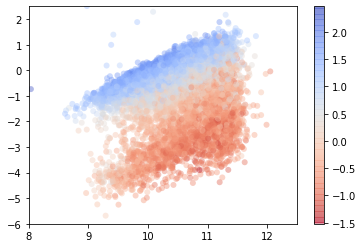

In [32]:
x=dataframe['log_Mass_no_corr']
y=dataframe['lSFR']
c=dataframe['EW_Ha_ALL'] 
x.to_numpy(dtype='float')
y.to_numpy(dtype='float')
c.to_numpy(dtype='float')
log_c=np.log10(np.abs(c))
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.4,edgecolor='none',cmap=cm)
axes.set_xlim([8,12.5])
axes.set_ylim([-6,2.5])
fig.colorbar(figure, ax=axes)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


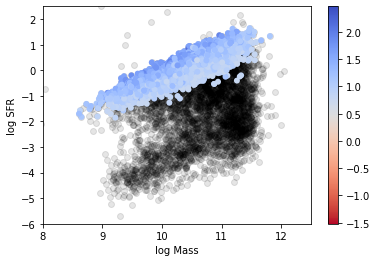

In [33]:
x=dataframe['log_Mass_no_corr']
y=dataframe['lSFR']
c=dataframe['EW_Ha_ALL'] 
x.to_numpy(dtype='float')
y.to_numpy(dtype='float')
c.to_numpy(dtype='float')
log_c=np.log10(np.abs(c))
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)
#
# We select SFGs
#
#df_SFGs=dataframe[(dataframe['EW_Ha_ALL']>-10000) & (dataframe['EW_Ha_ALL']<-6) & ((dataframe['lSFR']-dataframe['log_Mass_no_corr'])<-9.5) & (np.isfinite(dataframe['OH_Re_fit_O3N2'])) & (dataframe['z_stars']<0.05) & (dataframe['nsa_sersic_ba']>0.35) & (dataframe['nsa_sersic_n']<2.5) & (dataframe['frac_area_SFR_pure']>0.1)]
df_SFGs=dataframe[(dataframe['EW_Ha_ALL']>-10000) & (dataframe['EW_Ha_ALL']<-6) & ((dataframe['lSFR']-dataframe['log_Mass_no_corr'])<-9.5) & (np.isfinite(dataframe['OH_Re_fit_O3N2']))]
x_sf=df_SFGs['log_Mass_no_corr']
y_sf=df_SFGs['lSFR']
c_sf=df_SFGs['EW_Ha_ALL'] 
x_sf.to_numpy(dtype='float')
y_sf.to_numpy(dtype='float')
c_sf.to_numpy(dtype='float')
log_c_sf=np.log10(np.abs(c_sf))

figure=axes.scatter(x_sf, y_sf, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=1,edgecolor='none',cmap=cm)
axes.set_xlabel('log Mass')
axes.set_ylabel('log SFR')
axes.set_xlim([8,12.5])
axes.set_ylim([-6,2.5])
fig.colorbar(figure, ax=axes)

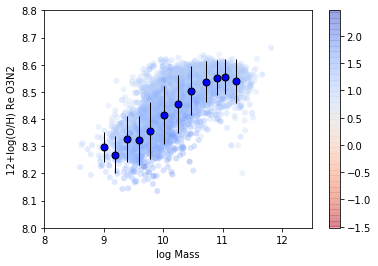

In [34]:
OH_sf=df_SFGs['OH_Re_fit_O3N2']
OH_sf.to_numpy(dtype='float')

fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
#figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)
figure=axes.scatter(x_sf, OH_sf, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)

bin1 , min1 , max1= 0.25,8.5,11.5
m1, OHM1, OHD1 = binning(x_sf, OH_sf, bin1 , min1 , max1 )
p1 = plt.errorbar(m1+0.2-0.10, OHM1, yerr= OHD1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )

axes.set_xlabel('log Mass')
axes.set_ylabel('12+log(O/H) Re O3N2')
axes.set_xlim([8,12.5])
axes.set_ylim([8,8.8])
fig.colorbar(figure, ax=axes)



CR M* vs 12+log O/H = 0.698336981457355
CR M* vs Delta_O/H = -0.07268647623319051


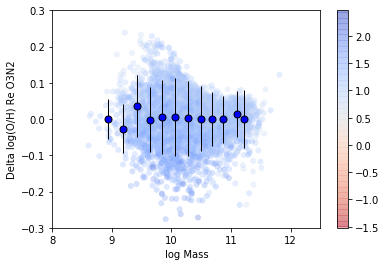

In [35]:
#
# You need to subtract the global trend (all) to describe possible secondary trends!
#

OH_smooth=np.interp(x_sf,m1,OHM1)
Delta_OH=OH_sf-OH_smooth
#print(Delta_OH)
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(x_sf, Delta_OH, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin1 , min1 , max1= 0.25,8.5,11.5
m1, OHM1, OHD1 = binning(x_sf, Delta_OH, bin1 , min1 , max1 )
p1 = plt.errorbar(m1+0.2-0.10, OHM1, yerr= OHD1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
axes.set_xlabel('log Mass')
axes.set_ylabel('Delta log(O/H) Re O3N2')
axes.set_xlim([8,12.5])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#
cr=np.corrcoef(x_sf,OH_sf)
print('CR M* vs 12+log O/H =',cr[0,1])
cr=np.corrcoef(x_sf,Delta_OH)
print('CR M* vs Delta_O/H =',cr[0,1])
#
# The correlation with M* disappears!
#

#
# If you see the mean points, there is residual trend with M*
#

/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


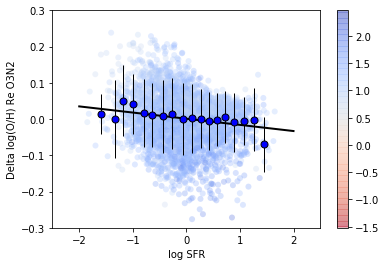

In [36]:
#
# Is there a secondary trend with the SFR?
#
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(y_sf, Delta_OH, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin2 , min2 , max2= 0.2,-2.5,2.5
s2, OHM2, OHD2 = binning(y_sf, Delta_OH, bin2 , min2 , max2 )
p1 = plt.errorbar(s2+0.1, OHM2, yerr= OHD2, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
funct3    = lambda x,a,b: a + b * x
s_plot=np.linspace(-2, 2, 10)
y_plot=funct3(s_plot,0.001,-0.017)
#
# Coefficients from the fitting in the next cell
#

f1 = plt.plot(s_plot, y_plot, '-k', linewidth = 2, markerfacecolor ='black'  , color ='black' )

axes.set_xlabel('log SFR')
axes.set_ylabel('Delta log(O/H) Re O3N2')
axes.set_xlim([-2.5,2.5])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#




In [37]:

#
# Now, which is the correlation coefficient?
#

cr=np.corrcoef(y_sf,OH_sf)
print('CR SFR vs 12+log O/H =',cr[0,1])
cr=np.corrcoef(y_sf,Delta_OH)
print('CR SFR vs Delta log O/H =',cr[0,1])
funct3    = lambda x,a,b: a + b * x
START=[0.01,0.01]
mask_OHM2=np.isfinite(OHD2) & np.isfinite(s2) & np.isfinite(OHD2)
#print(s2[mask_OHM2], OHM2[mask_OHM2])
pa1, ea1  = optimize.curve_fit(funct3, s2[mask_OHM2], OHM2[mask_OHM2], sigma=OHD2[mask_OHM2], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
#print('Coeffs lin fit SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3))
#print (pa1)
#
# The correlation with betwen Delta-O/H (residual of the MZR) and the SFR is very very weak!
#

#
# We substract the SFMS:
#
m3, SFR3, e_SFR3 = binning(x_sf, y_sf, bin1 , min1 , max1 )
SFMS_smooth=np.interp(x_sf,m3,SFR3)
Delta_SFMS=y_sf-SFMS_smooth
cr=np.corrcoef(Delta_SFMS,Delta_OH)
print('CR Delta_SFR vs Delta log O/H =',cr[0,1])
bin3,min3,max3=0.15,-0.5,0.5
DSFR4, DOH4, e_DOH4 = binning( Delta_SFMS, Delta_OH,bin3 , min3 , max3 )
mask_3=np.isfinite(DSFR4) & np.isfinite(DOH4) & np.isfinite(e_DOH4)
pa1, ea1  = optimize.curve_fit(funct3, DSFR4[mask_3], DOH4[mask_3], sigma=e_DOH4[mask_3], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, DSFR4[mask_3], DOH4[mask_3], p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
print('The slope of the possible secondary relation is almost ZERO. Far from the FMR')
print('The implementation would not change the ')
#
# The secondary trend, if any is very very weak!
#

#
# The slope of the secondary correlation is very very weak!!!!
# of the order of the ZERO!!!!!

#
# In summary, there is no general secondary correlation
#




CR SFR vs 12+log O/H = 0.5371075277227497
CR SFR vs Delta log O/H = -0.1817760266884514
Coeffs lin fit Delta_SFR vs. Delta_O/H= 0.001 0.004 -0.017 0.004
CR Delta_SFR vs Delta log O/H = -0.23200783442895292
Coeffs lin fit Delta_SFR vs. Delta_O/H= -0.003 0.003 -0.098 0.016
The slope of the possible secondary relation is almost ZERO. Far from the FMR
The implementation would not change the 


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
#
# I select now a range between 9.2 y 9.6
#


#
# Now, which is the correlation coefficient?
#

mask_Mass= (x_sf>=9.2) & (x_sf<9.6)
print('9.2 < log M* < 9.6')
cr=np.corrcoef(y_sf[mask_Mass],OH_sf[mask_Mass])
print('CR SFR vs 12+log O/H =',cr[0,1])
cr=np.corrcoef(y_sf[mask_Mass],Delta_OH[mask_Mass])
print('CR SFR vs Delta log O/H =',cr[0,1])
funct3    = lambda x,a,b: a + b * x
START=[1,1]
s2, OHM2, OHD2 = binning(y_sf[mask_Mass], Delta_OH[mask_Mass], bin2 , min2 , max2 )
mask_OHM2=np.isfinite(OHD2) & np.isfinite(s2) & np.isfinite(OHD2)
pa1, ea1  = optimize.curve_fit(funct3, s2[mask_OHM2], OHM2[mask_OHM2], sigma=OHD2[mask_OHM2], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
#print('Coeffs lin fit SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3))
print (pa1)
#
# The correlation with betwen Delta-O/H (residual of the MZR) and the SFR is very very weak!
#

#
# We substract the SFMS:
#
m3, SFR3, e_SFR3 = binning(x_sf, y_sf, bin1 , min1 , max1 )
SFMS_smooth=np.interp(x_sf,m3,SFR3)
Delta_SFMS=y_sf-SFMS_smooth
cr=np.corrcoef(Delta_SFMS,Delta_OH)
print('CR Delta_SFR vs Delta log O/H =',cr[0,1])
bin3,min3,max3=0.15,-0.5,0.5
DSFR4, DOH4, e_DOH4 = binning( Delta_SFMS, Delta_OH,bin3 , min3 , max3 )
mask_3=np.isfinite(DSFR4) & np.isfinite(DOH4) & np.isfinite(e_DOH4)
pa1, ea1  = optimize.curve_fit(funct3, DSFR4[mask_3], DOH4[mask_3], sigma=e_DOH4[mask_3], p0 = START )
#print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3))
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
#
# The secondary trend, if any is very very weak!
#

#
# The slope of the secondary correlation is very very weak!!!!
# of the order of the ZERO!!!!!

#
# In summary, there is no general secondary correlation
#

9.2 < log M* < 9.6
CR SFR vs 12+log O/H = -0.34600911780166255
CR SFR vs Delta log O/H = -0.39110878665011645


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Coeffs lin fit Delta_SFR vs. Delta_O/H= -0.045 0.028 -0.024 0.018
[-0.04468164 -0.0238318 ]
CR Delta_SFR vs Delta log O/H = -0.23200783442895292
Coeffs lin fit Delta_SFR vs. Delta_O/H= -0.003 0.003 -0.098 0.016


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


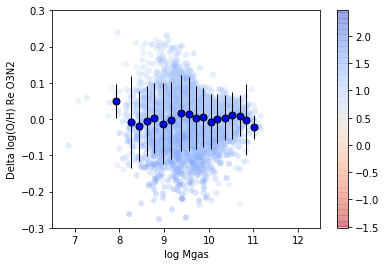

In [39]:
#
# Now we see if there is a secondary relation with Mgas
#
c_gas_sf=df_SFGs['log_Mass_gas'] 
c_gas_sf.to_numpy(dtype='float')
#
# Is there a secondary trend with the SFR?
#
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(c_gas_sf, Delta_OH, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin4 , min4 , max4= 0.2,7.5,11.5
mgas4, OHM4, OHD4 = binning(c_gas_sf, Delta_OH, bin4 , min4 , max4 )
p1 = plt.errorbar(mgas4+0.1, OHM4, yerr= OHD4, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
axes.set_xlabel('log Mgas')
axes.set_ylabel('Delta log(O/H) Re O3N2')
axes.set_xlim([6.5,12.5])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)

#print (pa1)

#
# There is no secondary relation with Mgas, even less than with SFR. The correlation is two weak with very low slope!
#

In [40]:
#
# If dependence is well removed, then there should be no secondary correlation
#
cr=np.corrcoef(c_gas_sf,OH_sf)
print('CR Mgas vs 12+log O/H =',cr[0,1])
cr=np.corrcoef(c_gas_sf,Delta_OH)
print('CR Mgas vs Delta log O/H =',cr[0,1])
funct3    = lambda x,a,b: a + b * x
START=[1,1]
mask_OHM4=np.isfinite(OHM4) & np.isfinite(mgas4) & np.isfinite(OHD4)
pa1, ea1  = optimize.curve_fit(funct3, mgas4[mask_OHM4], OHM4[mask_OHM4], sigma=OHD4[mask_OHM4], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_Mgas vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
#print('Coeffs lin fit Mgas vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3))

CR Mgas vs 12+log O/H = 0.6338648344206644
CR Mgas vs Delta log O/H = -0.05341299685253814
Coeffs lin fit Delta_Mgas vs. Delta_O/H= 0.138 0.036 -0.014 0.004


In [41]:
#
# Now for the range of masses 9.2-9.6
#
print('Relation of Mgas and O/H and Delta_O/H')
print('9.2 < Log M* < 9.6')
cr=np.corrcoef(c_gas_sf[mask_Mass],OH_sf[mask_Mass])
print('CR Mgas vs 12+log O/H =',cr[0,1])
cr=np.corrcoef(c_gas_sf[mask_Mass],Delta_OH[mask_Mass])
print('CR Mgas vs Delta log O/H =',cr[0,1])
funct3    = lambda x,a,b: a + b * x
START=[1,1]
mgas4, OHM4, OHD4 = binning(c_gas_sf[mask_Mass], Delta_OH[mask_Mass], bin4 , min4 , max4 )
mask_OHM4=np.isfinite(OHM4) & np.isfinite(mgas4) & np.isfinite(OHD4)
pa1, ea1  = optimize.curve_fit(funct3, mgas4[mask_OHM4], OHM4[mask_OHM4], sigma=OHD4[mask_OHM4], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
#print('Coeffs lin fit Mgas vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3))
print('So, the slope of the relation is -0.053, and the correlation coeff. is near ZERO!')
#
# The correlation coefficent indicate that there is no secondary relation!
#

Relation of Mgas and O/H and Delta_O/H
9.2 < Log M* < 9.6
CR Mgas vs 12+log O/H = -0.01278333871771195
CR Mgas vs Delta log O/H = -0.04875030660482114
Coeffs lin fit Delta_SFR vs. Delta_O/H= 0.476 0.33 -0.053 0.036
So, the slope of the relation is -0.053, and the correlation coeff. is near ZERO!


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


N.gals SFGs in the v2.7.1 = 3549


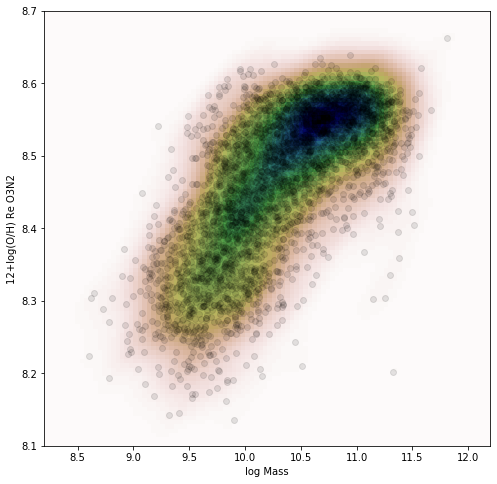

In [42]:

fig, axes = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('viridis')
#figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)
xmin=8.2
xmax=12.2
ymin=8.1
ymax=8.7


X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x_sf,OH_sf])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)
axes.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
            extent=[xmin, xmax, ymin, ymax])
figure=axes.scatter(x_sf, OH_sf, color='black', alpha=0.1) #, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.01,edgecolor='none',cmap=cm)
#fig.colorbar(figure, ax=axes)
axes.set_xlabel('log Mass')
axes.set_ylabel('12+log(O/H) Re O3N2')
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
axes.axis('tight')

print('N.gals SFGs in the v2.7.1 =',OH_sf.size)


6.85824116493739
11.1735576052738


(8.2, 12.2, 8.1, 8.7)

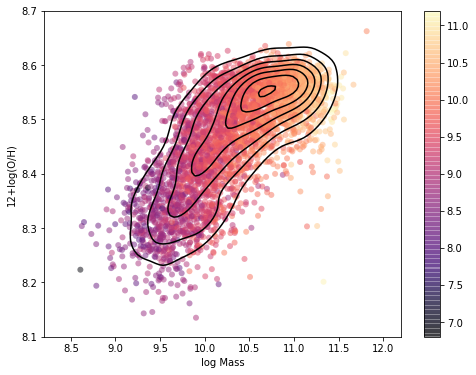

In [43]:

fig, axes = plt.subplots(figsize=(8,6))
cm = plt.cm.get_cmap('magma')

print(np.amin(c_gas_sf))
print(np.amax(c_gas_sf))
figure=axes.scatter(x_sf, OH_sf, alpha=0.5, c=c_gas_sf, vmin=6.8,vmax=11.2,edgecolor='none',cmap=cm)
CS=axes.contour(X, Y, Z, colors='k')
fig.colorbar(figure, ax=axes)
axes.set_xlabel('log Mass')
axes.set_ylabel('12+log(O/H)')
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
axes.axis('tight')




In [44]:
# NOW we replicate the selection criteria that you have applied

NOW we replicate the selection criteria:

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


N.gals SFGs in the v2.7.1 (+ Laura sel.)= 1684


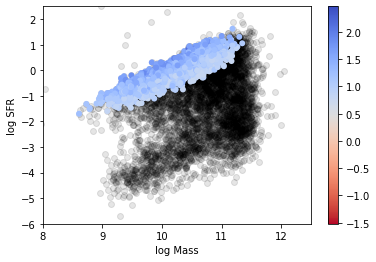

In [45]:
x=dataframe['log_Mass_no_corr']
y=dataframe['lSFR']
c=dataframe['EW_Ha_ALL'] 
x.to_numpy(dtype='float')
y.to_numpy(dtype='float')
c.to_numpy(dtype='float')
log_c=np.log10(np.abs(c))
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)

# We add more restrictions:
# (1)  z<0.05  3544 -> 2917
# (2) Elip = sqrt(1-ab^2) 2917 -> 2166
# (3) T>1 => This is difficult to replicate, but we use the sersic index <2.5  2166 -> 1764
# (4) QC. I got for granted.
# (5) Number of spaxels... i use the 'frac_area_SFR_pure' parameter > 10%  1764 -> 1682 (enough points to make statistics!)
df_SFGs=dataframe[(dataframe['EW_Ha_ALL']>-10000) & (dataframe['EW_Ha_ALL']<-6) & ((dataframe['lSFR']-dataframe['log_Mass_no_corr'])<-9.5) & (np.isfinite(dataframe['OH_Re_fit_O3N2'])) & (dataframe['z_stars']<0.05) & (dataframe['nsa_sersic_ba']>0.35) & (dataframe['nsa_sersic_n']<2.5) & (dataframe['frac_area_SFR_pure']>0.1)]
x_sf=df_SFGs['log_Mass_no_corr']
y_sf=df_SFGs['lSFR']
c_sf=df_SFGs['EW_Ha_ALL'] 
x_sf.to_numpy(dtype='float')
y_sf.to_numpy(dtype='float')
c_sf.to_numpy(dtype='float')
log_c_sf=np.log10(np.abs(c_sf))

figure=axes.scatter(x_sf, y_sf, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=1,edgecolor='none',cmap=cm)
axes.set_xlabel('log Mass')
axes.set_ylabel('log SFR')
axes.set_xlim([8,12.5])
axes.set_ylim([-6,2.5])
fig.colorbar(figure, ax=axes)


OH_sf=df_SFGs['OH_Re_fit_O3N2']
OH_sf.to_numpy(dtype='float')

print('N.gals SFGs in the v2.7.1 (+ Laura sel.)=',x_sf.size)


Min Mgas= 6.85824116493739
Max Mgas= 10.689783338238401
CR M* vs O/H [9.2,9.6]= [[1.         0.71084609]
 [0.71084609 1.        ]]


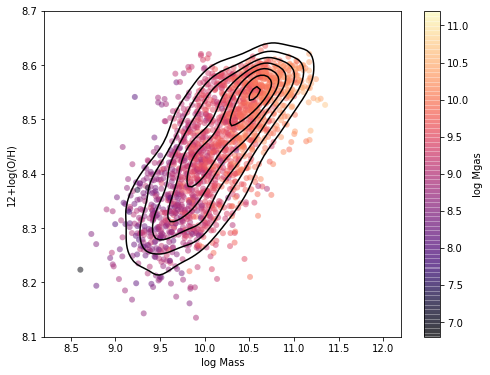

In [46]:
cm = plt.cm.get_cmap('viridis')
#figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)
xmin=8.2
xmax=12.2
ymin=8.1
ymax=8.7
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x_sf,OH_sf])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

fig, axes = plt.subplots(figsize=(8,6))
cm = plt.cm.get_cmap('magma')
c_gas_sf=df_SFGs['log_Mass_gas'] 
c_gas_sf.to_numpy(dtype='float')
print('Min Mgas=',np.amin(c_gas_sf))
print('Max Mgas=',np.amax(c_gas_sf))
figure=axes.scatter(x_sf, OH_sf, alpha=0.5, c=c_gas_sf, vmin=6.8,vmax=11.2,edgecolor='none',cmap=cm)
CS=axes.contour(X, Y, Z, colors='k')
fig.colorbar(figure, ax=axes, label='log Mgas')
axes.set_xlabel('log Mass')
axes.set_ylabel('12+log(O/H)')
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
axes.axis('tight')
cr=np.corrcoef(x_sf,OH_sf)
print('CR M* vs O/H [9.2,9.6]=',cr)
#
# Interesting the change in the shape of the MZR...
# To force having enough numbner of points is maybe too strick!
# The largest Mgas have disappear!

CR Mgas vs O/H [9.2,9.6]= [[ 1.         -0.04572939]
 [-0.04572939  1.        ]]


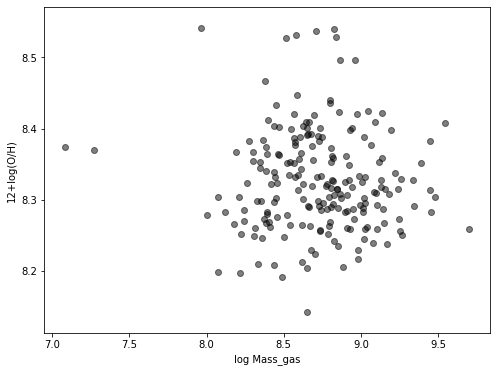

In [47]:
#
# Now a select the galaxies within the mass range between 9.2 and 9.6
#
mask= (x_sf>=9.2) & (x_sf<9.6)
x_mask=x_sf[mask]
y_mask=y_sf[mask]
OH_mask=OH_sf[mask]
m_gas_mask=c_gas_sf[mask]

fig, axes = plt.subplots(figsize=(8,6))
cm = plt.cm.get_cmap('magma')
figure=axes.scatter(m_gas_mask, OH_mask, alpha=0.5, color='black') #c=c_gas_sf, vmin=6.8,vmax=11.2,edgecolor='none',cmap=cm)
axes.set_xlabel('log Mass_gas')
axes.set_ylabel('12+log(O/H)')
axes.set_xlim([6,11])
axes.set_ylim([ymin,ymax])
axes.axis('tight')
cr=np.corrcoef(m_gas_mask,OH_mask)
print('CR Mgas vs O/H [9.2,9.6]=',cr)


CR Mgas vs O/H = [[1.         0.62254459]
 [0.62254459 1.        ]]


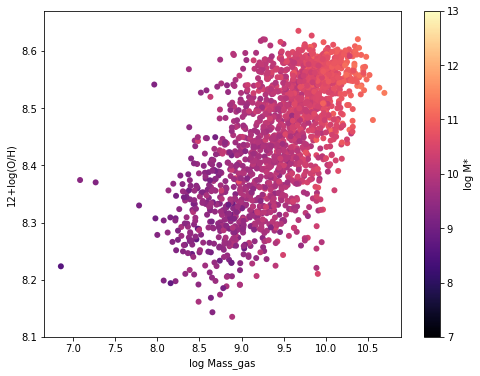

In [48]:
#
# Now a select the galaxies within the mass range between 9.2 and 9.6
#
fig, axes = plt.subplots(figsize=(8,6))
cm = plt.cm.get_cmap('magma')
figure=axes.scatter(c_gas_sf, OH_sf, c=x_sf, vmin=7,vmax=13,edgecolor='none',cmap=cm)
axes.set_xlabel('log Mass_gas')
axes.set_ylabel('12+log(O/H)')
axes.set_xlim([6,11])
axes.set_ylim([ymin,ymax])
fig.colorbar(figure, ax=axes, label='log M*')
axes.axis('tight')
cr=np.corrcoef(c_gas_sf,OH_sf)
print('CR Mgas vs O/H =',cr)